In [1]:
import numpy as np
import pandas as  pd
import tensorflow as tf
from tensorflow import keras
#import keras
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from sklearn import *
import math
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from ipynb.fs.defs.UtilitiesVED import *
plt.rcParams["figure.figsize"] = (20,10)
tf.autograph.set_verbosity(0)

## Import Data


In [46]:
X = pd.read_csv("../Data/data_UE1_600/X_600_TTI.csv", index_col=0)
y = pd.read_csv("../Data/data_UE1_600/y_600_TTI.csv", index_col=0)



(590, 5120)

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, shuffle=False)

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(354, 1280)
(354, 3840)
(236, 1280)
(236, 3840)


In [5]:
X_train = (X_train.to_numpy())
X_test = (X_test.to_numpy())
y_train = (y_train.to_numpy())
y_test = (y_test.to_numpy())

In [6]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_esc = scaler.transform(X_train)
X_test_esc = scaler.transform(X_test)

## Create a sampling layer


## Build the encoder


In [7]:
latent_dim = 50 # Latent Space dimension on the bottleneck
input_dim = X_train.shape[1]
ReLu = keras.layers.ReLU()

encoder_inputs = keras.Input(shape=( input_dim, ))
x = layers.Dense(309, activation=ReLu)(encoder_inputs)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x000001D55E9ACCA0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1280)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 309)          395829      ['input_1[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 50)           15500      

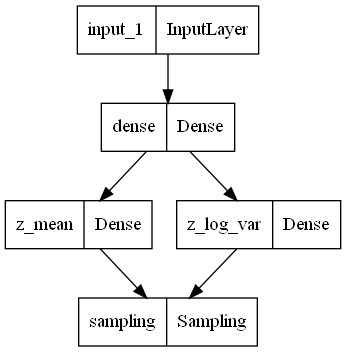

In [8]:
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(encoder, to_file='encoder.png')

## Build the decoder


In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(50,  activation=ReLu)(latent_inputs)
decoder_outputs = layers.Dense(input_dim * 3, activation="linear")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 3840)              195840    
                                                                 
Total params: 198,390
Trainable params: 198,390
Non-trainable params: 0
_________________________________________________________________


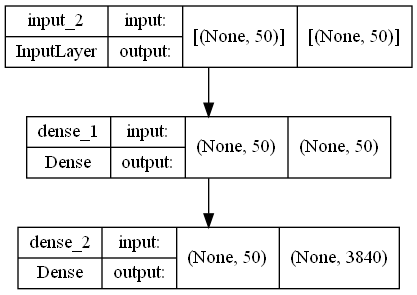

In [10]:
plot_model(decoder,  show_shapes=True, show_layer_names=True)

## Define the VAE as a Model with a custom train_step


## Train the VAE

In [11]:
vae = VAE(encoder, decoder, 1)

In [12]:
vae.compile(optimizer=keras.optimizers.Adam())

In [13]:
es = keras.callbacks.EarlyStopping(
    monitor="MAE",
    patience=4,
)

In [14]:
history = vae.fit(X_train_esc, y_train, validation_data=(X_test_esc, y_test), epochs=50, batch_size=4)#, callbacks=es)

Epoch 1/50
89/89 [==============================] - 2s 8ms/step - loss: 36.3348 - MSE: 0.0212 - kl_loss: 27.0716 - val_loss_val: 27.4238 - val_MSE_val: 0.0149 - val_kl_loss_val: 27.4088
Epoch 2/50
89/89 [==============================] - 1s 6ms/step - loss: 13.0921 - MSE: 0.0134 - kl_loss: 12.1658 - val_loss_val: 23.2731 - val_MSE_val: 0.0128 - val_kl_loss_val: 23.2603
Epoch 3/50
89/89 [==============================] - 1s 8ms/step - loss: 8.8868 - MSE: 0.0124 - kl_loss: 8.1713 - val_loss_val: 19.9069 - val_MSE_val: 0.0121 - val_kl_loss_val: 19.8948
Epoch 4/50
89/89 [==============================] - 1s 8ms/step - loss: 5.6098 - MSE: 0.0121 - kl_loss: 5.4034 - val_loss_val: 17.7054 - val_MSE_val: 0.0117 - val_kl_loss_val: 17.6937
Epoch 5/50
89/89 [==============================] - 1s 8ms/step - loss: 4.3177 - MSE: 0.0119 - kl_loss: 4.0668 - val_loss_val: 16.1324 - val_MSE_val: 0.0116 - val_kl_loss_val: 16.1208
Epoch 6/50
89/89 [==============================] - 1s 8ms/step - loss: 3.36

Epoch 46/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0713 - MSE: 0.0115 - kl_loss: 0.0602 - val_loss_val: 2.0653 - val_MSE_val: 0.0110 - val_kl_loss_val: 2.0543
Epoch 47/50
89/89 [==============================] - 0s 5ms/step - loss: 0.0726 - MSE: 0.0115 - kl_loss: 0.0608 - val_loss_val: 1.9747 - val_MSE_val: 0.0110 - val_kl_loss_val: 1.9637
Epoch 48/50
89/89 [==============================] - 1s 6ms/step - loss: 0.0748 - MSE: 0.0115 - kl_loss: 0.0601 - val_loss_val: 1.8627 - val_MSE_val: 0.0110 - val_kl_loss_val: 1.8517
Epoch 49/50
89/89 [==============================] - 0s 5ms/step - loss: 0.0613 - MSE: 0.0115 - kl_loss: 0.0513 - val_loss_val: 1.8080 - val_MSE_val: 0.0110 - val_kl_loss_val: 1.7970
Epoch 50/50
89/89 [==============================] - 0s 5ms/step - loss: 0.0643 - MSE: 0.0115 - kl_loss: 0.0495 - val_loss_val: 1.7069 - val_MSE_val: 0.0110 - val_kl_loss_val: 1.6959


In [15]:
print(history.history.keys())

dict_keys(['loss', 'MSE', 'kl_loss', 'val_loss_val', 'val_MSE_val', 'val_kl_loss_val'])


In [16]:


print('NRMSE', nrmse(vae.predict(X_test), y_test))
print('MAE', mae(vae.predict(X_test), y_test))
print('RMSE', math.sqrt(mse(vae.predict(X_test), y_test)))
print('MSE', mse(vae.predict(X_test), y_test))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x000001D563F5ED00>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
NRMSE 1.020381082114303
MAE 11.800756261027152
RMSE 1.6099808275045115
MSE 2.592002798696899


# PLOTS


In [17]:
y_pred = vae.predict(X_test_esc)

In [18]:
samp_num = 1

In [19]:
name_ds = 'UE1'

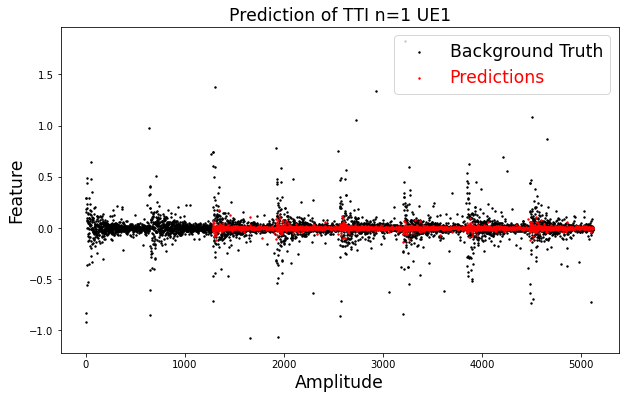

In [20]:
plot_1TTI(y_test, y_pred, X_test, samp_num, name_ds)



In [21]:
print(history.history.keys())

dict_keys(['loss', 'MSE', 'kl_loss', 'val_loss_val', 'val_MSE_val', 'val_kl_loss_val'])


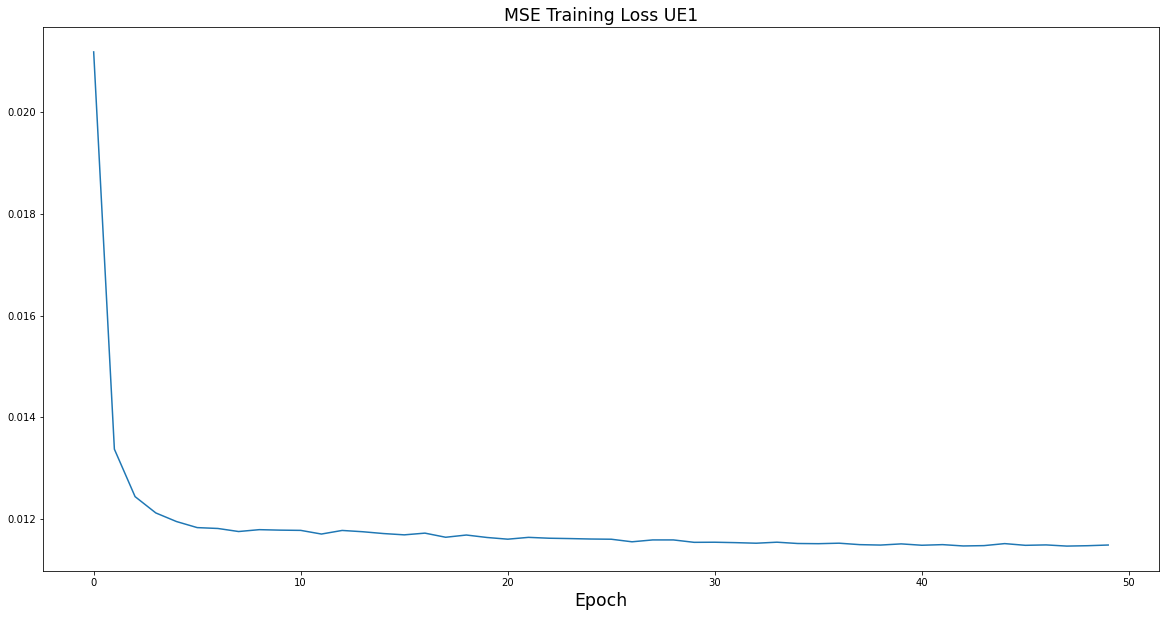

In [22]:
plot_mse_loss(history, name_ds)

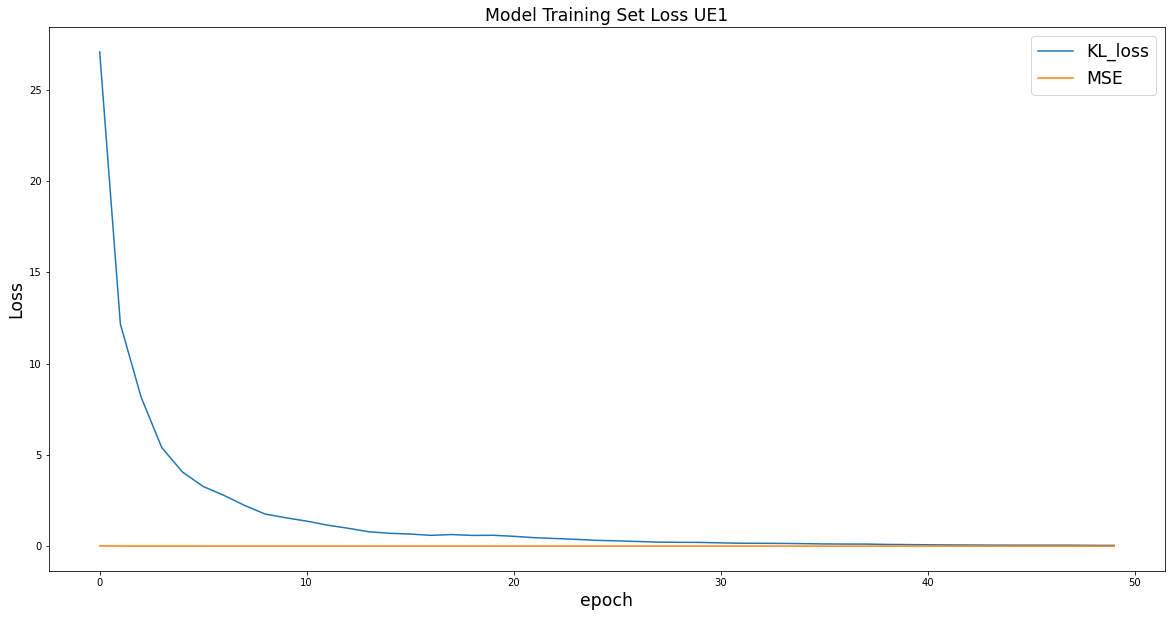

In [23]:
plot_kl_mse(history, name_ds)
    


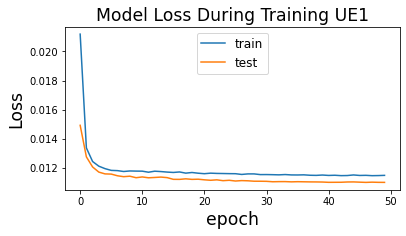

In [24]:
# summarize history for accuracy
plot_train_test(history, name_ds)


In [25]:
y_test.shape

(236, 3840)

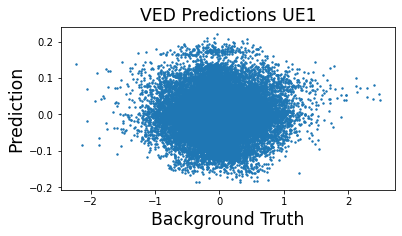

In [26]:
plot_pred_vs_true(y_pred, y_test, name_ds)

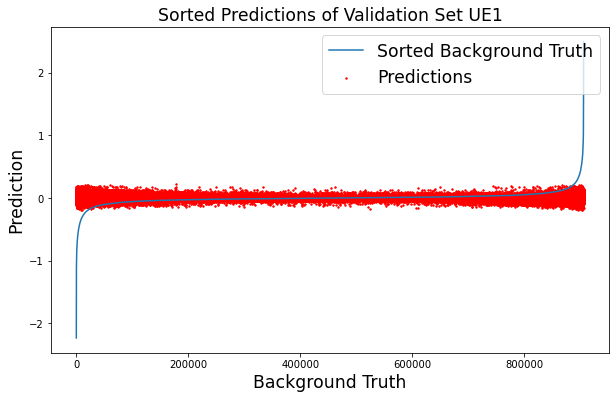

In [27]:
plot_sorted_vs_true(y_pred, y_test, name_ds)

    

# 

# Modeling

In [30]:
import scipy
data = pd.read_csv("../Data/data_UE1_600/data_unfold_UE1_600.csv", index_col=0).values

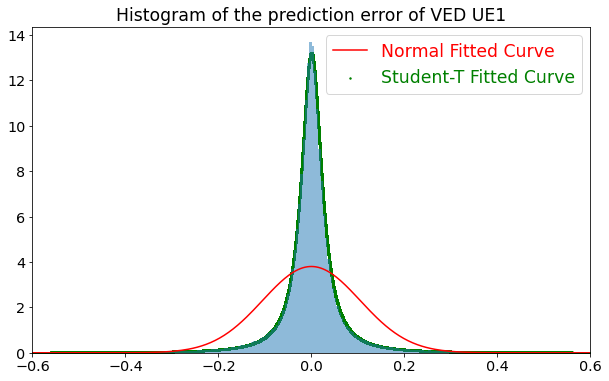

In [32]:
plot_modeling_prediction_error(data, y_test, y_pred, name_ds, nbins=1000)

# Reconstruct the validation set

In [33]:
from matplotlib.pyplot import *


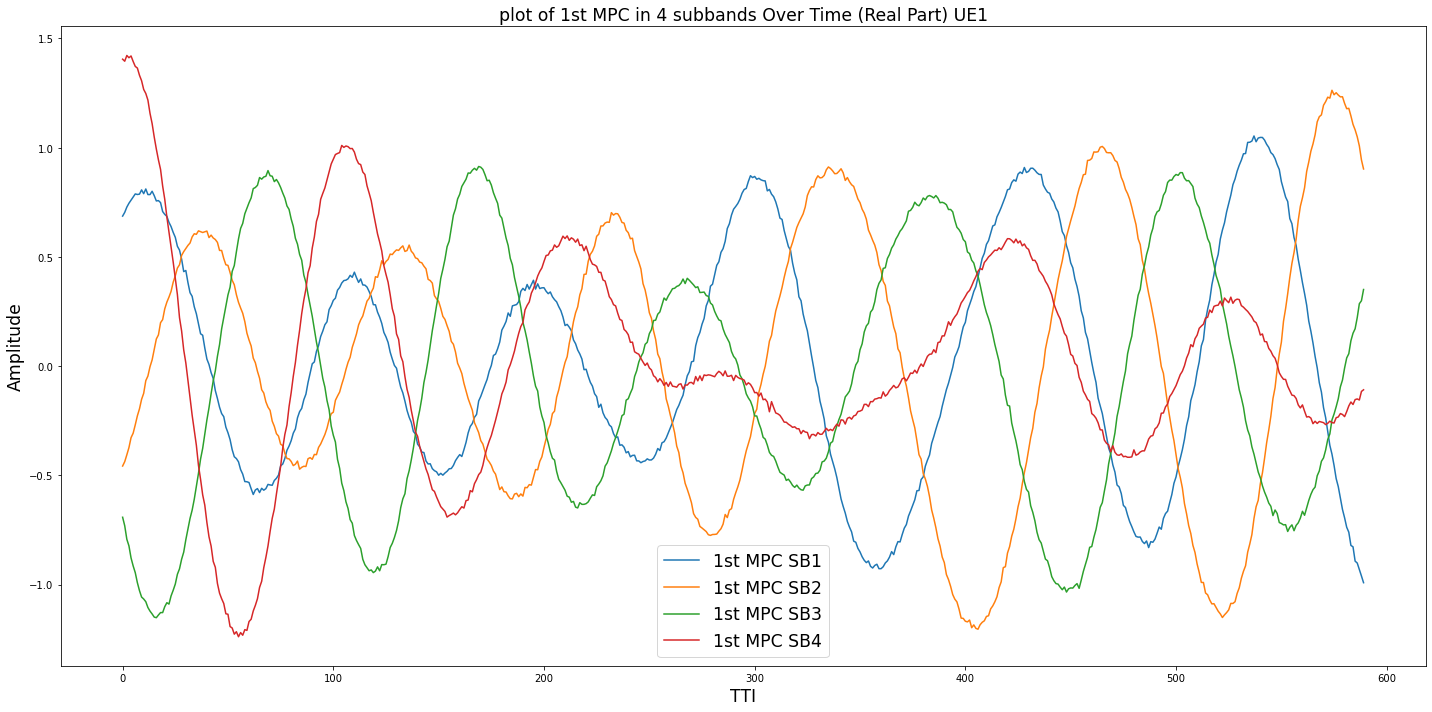

In [34]:
mpc=640

plot_MPC_overtime(data, mpc, name_ds, True)

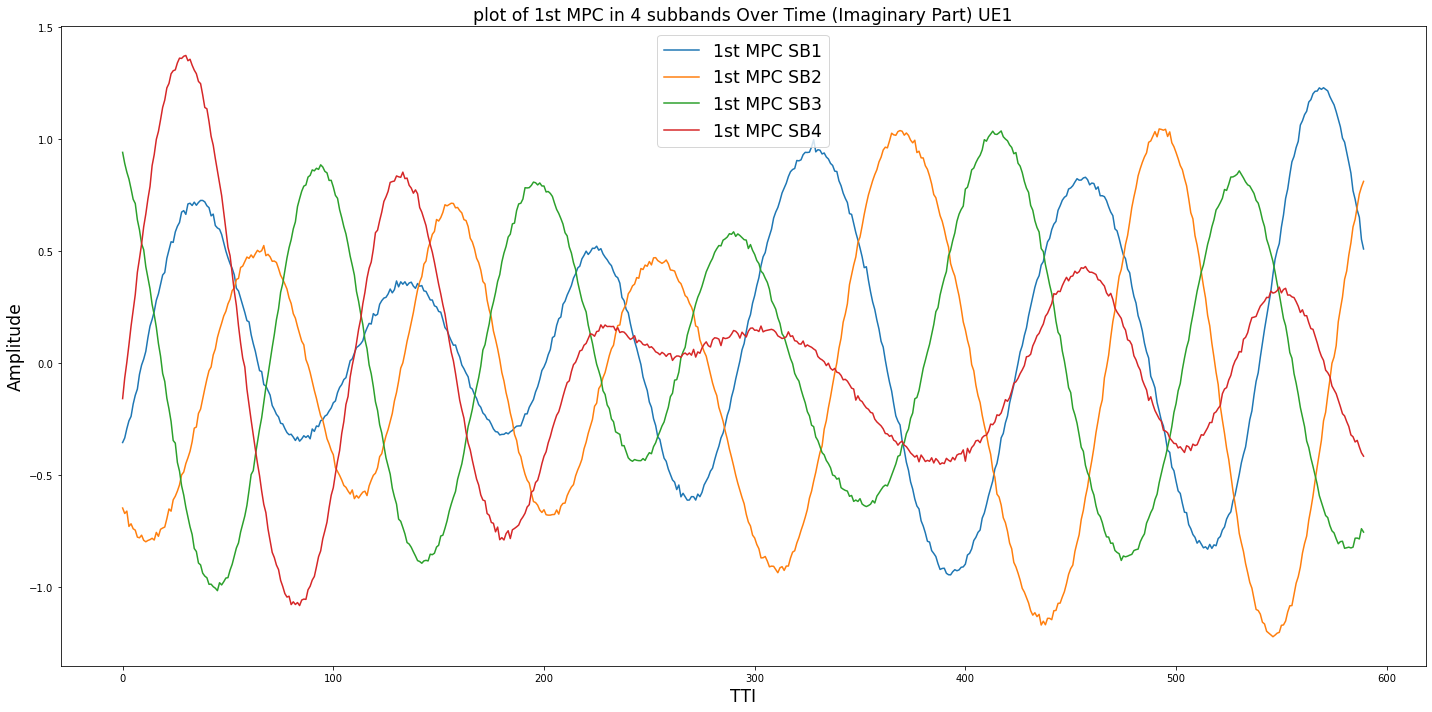

In [35]:
plot_MPC_overtime(data, mpc, name_ds, False)

# Reconstruct the validation set

In [36]:
y_pred = vae.predict(X_test_esc)


In [37]:
reconstruct_valid = reconstruct_validation(mpc, y_pred, X_test)


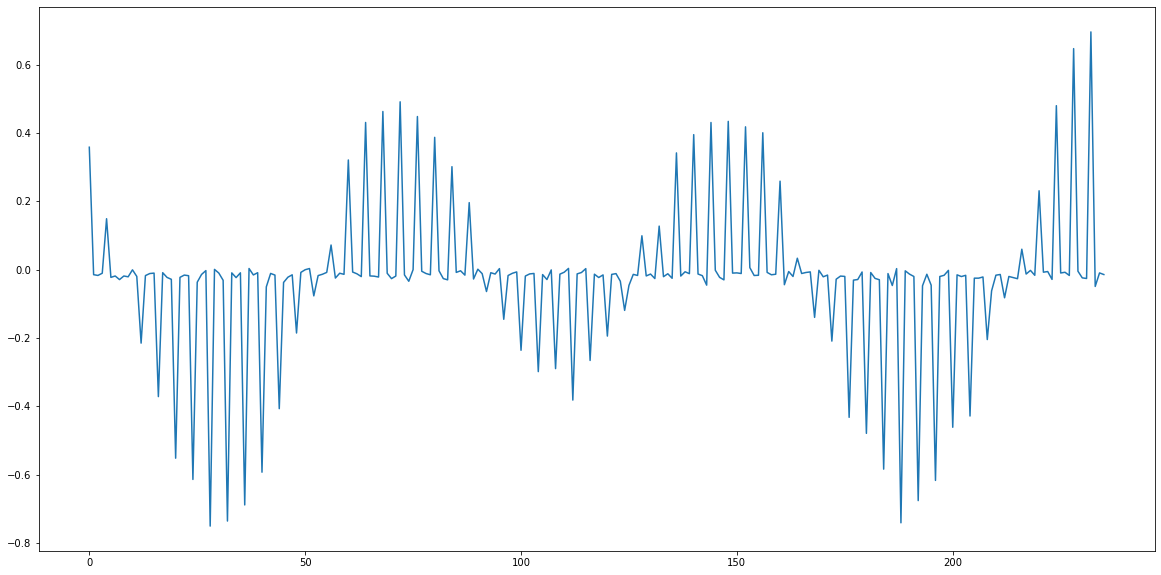

In [39]:
plot(reconstruct_valid[:,1])

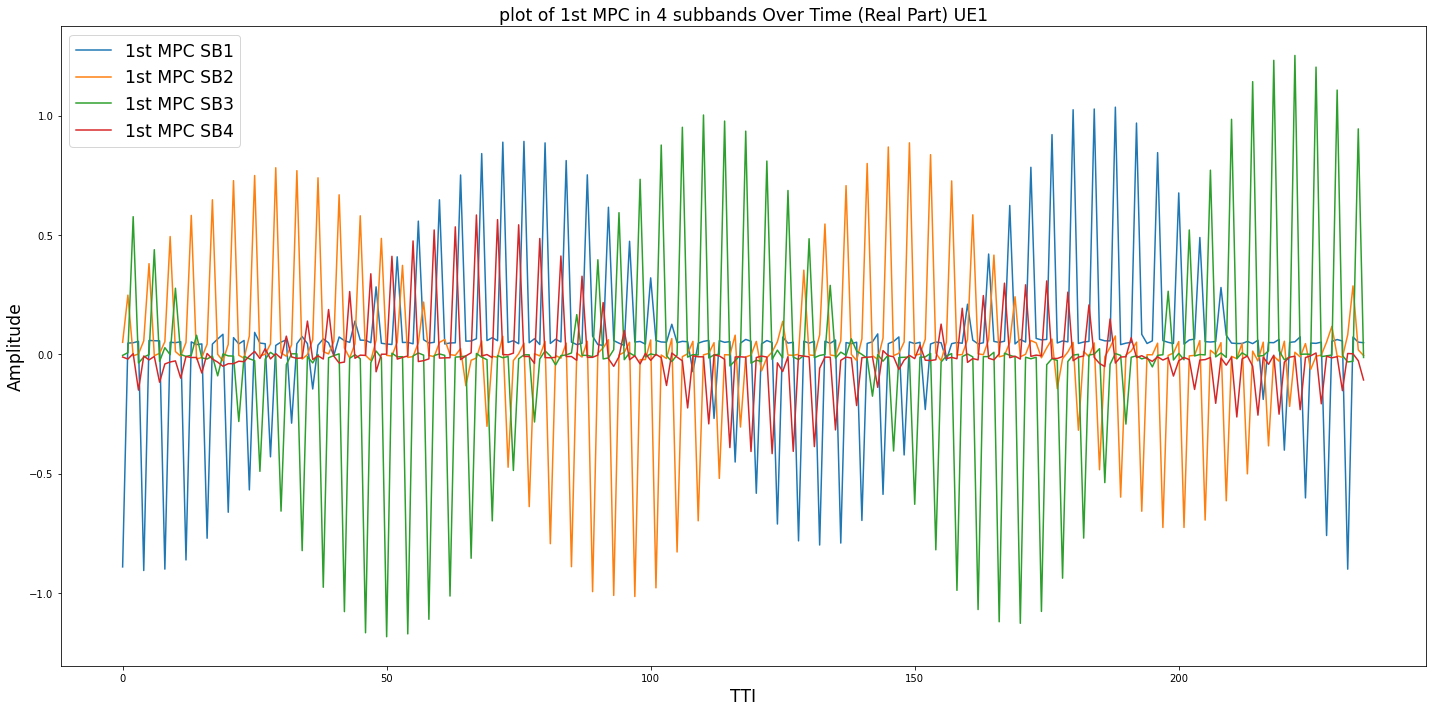

In [40]:
plot_MPC_overtime(reconstruct_valid, mpc, name_ds, True)
